### Theory behind ML potentials

The total potential energy of a structure can be represented as summation of potential energies of constituent atoms.

\begin{equation}
U=\sum_{i=1}^{N_a} U_i
\end{equation}

The potential energy of an atom is due to its interaction with atoms surrounding it. The major contribution to $U_i$ comes from the atoms that are located within certain cutoff distance. The distribution of atoms around atom $i$ is captured with the following equation. 

\begin{equation}
\rho_i(\mathbf{r})=\sum_{j=1}^{N_a} f_{\mathrm{cut}}\left(r_{i j}\right) g\left(\mathbf{r}-\mathbf{r}_{i j}\right)
\end{equation}

Where, $\rho_i$ is probability for finding an atom j at distance $r$, and $g(r)$ is delta function. The summation includes all the atoms in the structure, while $f_cut$ removes the contribution from atoms located outside of the cutoff sphere. 

ML potentials rely on the local nature of potential energy. Therefore the chosen cutoff should be large enough to capture all the major interactions that contribute to forces atoms experience. While VASP defaults (RCUT1 = RCUT2 = 5 A for 6.3 version and RCUT1 = 8 A, RCUT2 = 5 A for version 6.4.2, where RCUT1 is cutoff for radial, and RCUT2 is cutoff for angular descriptors) are good enough for most of the cases it is worthwhile to look at RDFs for your structure and choose cutoff distance that works for your system. It is also possible to retrain an ML potential with a different cutoff later on. 

The potential energy of an atom is a functional of these radial and angular descriptors. 

\begin{equation}

U_i=F\left[\rho_i^{(2)}, \rho_i^{(3)}\right]

\end{equation}

Where, F is the functional form, $\rho_i^{(2)}$ and $\rho_i^{(3)}$ are radial and angular descriptors. They are equivalent representation of $\rho_i$ with added rotational and translational invariance. It is also possible to adjust the number of components they are represented with (the terms in Taylor expansion) by specifying ML_MRB1 and ML_MRB2 respectively in the INCAR file. Choosing larger or smaller numbers than the defaults could improve accuracy or efficiency respectively. The defaults are okay and would need tweaking only in special circumstances. 

The basic idea behind ML algorithm is storing significant atom environments termed as local configurations, in a basis set and calculating energies and forces in sampled atom environments by assessing their similarity to the environments stored in the basis set. Thus first steps of the training involve creating this basis set by adding most of the local environments in initial and subsequent structures (therefore starting from an equilibrated POSCAR could be a thoughtful act). When a new structure is encountered during training, its local environments are compared to each local configuration in the basis set. The function that assesses similarity is called kernel function. It is a function of $X_i$ and $X_{i_B}$, which stand for the vectors that contain the coefficients in the descriptor space for atom $i$ in the structure and atom $i_B$ from the basis set. The energy, functional form of radial and angular descriptors, is a weighted sum of kernel functions. These weighting factors $w_{i_B}$ are the coefficients determined during the fitting.

\begin{equation}

F\left[\rho_i^{(2)}, \rho_i^{(3)}\right]=\sum_{i_B=1}^{N_B} w_{i_B} K\left(\mathbf{X}_{i}, \mathbf{X}_{i_B}\right)

\end{equation}

### Efficiency vs accuracy
After new structures are added to the training set, the local configurations that are dissimilar with the basis set are included to the basis set for refitting. High number of local configurations means more resource intensive fitting and less efficient force field. To sample local configurations that enhance predictive power of the FF throughout the training without running into memory issues, at each fitting the local configurations that have low weighting factors are discarded. This process is called sparsification and is associated with sparsification criterion (ML_EPS_LOW) that determines the lower threshold for weighting factor. Discarding local configurations also affects the accuracy. Therefore it is essential to use sparsification criterion that protects the balance between accuracy and efficiency.

### Training
Setting up the MLFF training is very similar with setting up an AIMD calculation. It is recommended to run a short AIMD first to verify consistent electronic convergence and to test the setup for molecular dynamics simulation. Three main requirements dominate the choices we make in terms of the setup for MLFF training. These are accuracy, robustness and efficiency. 

It is essential that force field learns accurate forces to be able to make accurate predictions. Therefore, the choice of cutoff energy and k-point mesh should follow similar standards used in DFT for structure relaxations. This is a very important point to stress. An MLFF training is in a nutshell learning while running AIMD. Historically the community preference was towards lower ENCUT, coarser k-point mesh and looser convergence criterion (EDIFF > 1e-4 which is default in VASP 6.4), because lowering quality of DFT performed at every step was only way to obtain sufficiently long trajectory without waiting for a lifetime for calculations to finish. However, speed is less of an issue for on-the-fly training, since FP calculations are performed every N step where N increases as forcefield gets better and better. In training runs the most important is providing forcefield with accurate energies and forces, which means higher ENCUTs (30% higher than ENMAX given training is done in NPT), fine k-point mesh (to be determined with convergence testing), and tighter convergence criterion (EDIFF = 1e-6). Doing otherwise can introduce noise in training data and result in systematic errors. Therefore it is highly recommended to choose settings that result in high accuracy rather than lowers cost. It is possible to reduce the costs by training on small cells. In this case the minimum cell size should be large enough to contain primary phonon modes. In my own trainings I found it useful to train on a system that is large enough for gamma point sampling as using VASP binary for gamma point only also increases the speed few times. 

The force field should also be robust. It should retain its predictive power when it is used in conditions different than which it was trained at. These conditions involve different pressures, temperatures, supercell sizes and lattice parameters. The robust and accurate force fields are also able to differentiate between polymorphs as demonstrated in studies that use them to look at phase transitions \cite{jinnouchi2019phase}. To ensure their robustness it is recommended to train them in NPT ensemble and use the Langevin thermostat. Changes in cell size and shape as well as stochastic nature of Langevin thermostat ensures training of a robust MLFF.

The acceleration that MLFF provides compared to AIMD is a measure of its efficiency. The lower the number of structures in reference datasets and the local reference configurations in the basis set the higher is the efficiency of an MLFF. There is a trade-off between accuracy and universality of the force field. As we train the force field at higher temperatures and pressures, we are trying to fit it to a larger portion of the PES. Thus the accuracy of the fit becomes worse. Therefore it is essential to not overtrain the MLFF beyond needs of an application. When the root mean square error (RMSE) levels off at the given training condition, this is the sign that training phase can be terminated. If a more universal force-field is desired to study two phase systems or behaviour of a material in a wide temperature range, training could accumulate large number of local configurations. It is also possible to reduce their number by using more aggressive sparsification criterion. However the accuracy should be monitored. VASP recommendation is training the forcefield up to 30% higher temperature than its desired use temperature.

Below is an example input script for the first training. In this training I start with DFT relaxed Li2SiS3 structure in form of 3x3x2 supercell (432 atoms) and heat it from 10 K to 300 K within 20 ps. I could also start learning with a constant temperature run at 300 K, which would require additional equilibration AIMD to get a suitable starting structure. Since running ML training makes AIMD considerably faster, I opted for a heating run as a first training. The runs that follow this one were constant temperature training at 300 K for 20 more ps, heating to 500 K for 20 ps, constant T run at 500 K for 20 ps, heating to 780 K for 20 ps, training at 780 K for 20 ps. The final training temperature chosen as 780 K, as desired upper T to use this potential chosen was 600 K.

In [ ]:
SYSTEM         = Li2SiS3_tetragonal_heating
### Electronic structure part
PREC           = Normal
ADDGRID        = .TRUE.
GGA            = PS
ALGO           = Fast
ENCUT          = 650
EDIFF          = 1e-6
NELM           = 400
NELMIN         = 6
ISPIN          = 1  
ISYM           = 0
ISMEAR         = 0  
SIGMA          = 0.05

### MD part 
IBRION         = 0            #sets up MD
ISIF           = 3            #allows cell shape and volume change
MDALGO         = 3            #sets langevin thermostat 
SMASS          = -1           #ensure T scaling every NBLOCK steps
NSW            = 10000 
POTIM          = 2             
NCORE          = 20           #set for use in michael A nodes. Make it multiples of 8 or 16 for use in isambard or archer
NBLOCK         = 20
TEBEG          = 10
TEEND          = 300
RANDOM_SEED    = 743491 0 0               #useful to set a random seed for training runs and use it throughout
LANGEVIN_GAMMA   = 10.0  10.0  10.0       #langevin thermostat parameters 
LANGEVIN_GAMMA_L = 3.0                   

### Output part
LREAL          = Auto
LWAVE          = .FALSE.
LCHARG         = .FALSE.

### ML primary tags
ML_LMLFF = .TRUE.             #ML training, use is on
ML_ISTART = 0                 #training is starting from scratch
ML_CX = -0.1                  #to increase frequency of Ab-initio steps, recommended for training at low T
ML_MB = 3000                  #max # of local configurations stored for each element

### Monitoring

The procedure followed for Li2SiS3 potential training shown above is the ideal scenario. However, not all the trainings go till completion. They stop for different reasons. First of these reasons might be reaching walltime limit. In this case one can restart the training by copying ML_ABN file into ML_AB file and CONTCAR to POSCAR in another simulation directory and restrating the training with ML_ISTART = 1. 

ML_MB flag specified in INCAR determines number of rows in the design matrix that is initialised at the beginning of each training run. It is also maximum number of local configurations for each element. It is generally a good idea to set this value to higher number than the highest number of local configurations in ML_AB file. The training does not stop if the number of local configurations added reach ML_MB, but it becomes much slower. Therefore it is recommended to start with higher ML_MB and when increasing it further does not make sense (increasing ML_MB means increasing memory overhead. If the memory requirement is large sometimes simulation might run until walltime limit without adding any structures to training) doing a retraining run with lower ML_MB to eliminate excess local configurations with the least contribution. Large number of local configurations make the fitting slower and the forcefield less efficient. For solid electrolytes 3000 - 3500 can be good number for maximum local configurations, in final forcefield.

Monitoring the training involves looking at how often potential needs training, how BEEF and actual error (calculated every FP calculation step) evolve over time and whether new local configurations are added to the training. The following signal that force field is trained enough in PES corresponding to given simulation conditions; the force field is training ("learning" and "critical" steps) less and less and predicts mostly what it considers "accurate"; RMSE (actual error) levels off; and there are less and less local configurations added the training step. In the following section the relevant data is extracted from ML_LOGFILE to plot these observables.



In [2]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio

# plotting learning rate wrt steps

! grep STATUS ML_LOGFILE|grep -E 'learning'|grep -v "#" > ./learning.dat
! grep STATUS ML_LOGFILE|grep -E 'critical'|grep -v "#" > ./critical.dat
! grep STATUS ML_LOGFILE|grep -E 'accurate'|grep -v "#" > ./accurate.dat

steps_learning = np.loadtxt("./learning.dat", 
                       usecols=[1], unpack=True)
y_learning = [3]*len(steps_learning)

steps_critical = np.loadtxt("./critical.dat", 
                       usecols=[1], unpack=True)

y_critical = [2]*len(steps_critical)
                    
steps_accurate = np.loadtxt("./accurate.dat", 
                       usecols=[1], unpack=True)

y_accurate = [1]*len(steps_accurate)

fig = go.Figure()

fig.add_trace(go.Scatter(x = steps_learning, y = y_learning, mode='markers', name='learning'))
fig.add_trace(go.Scatter(x = steps_critical, y = y_critical, mode='markers', name='critical'))
fig.add_trace(go.Scatter(x = steps_accurate, y = y_accurate, mode='markers', name='accurate'))
fig.update_yaxes(visible=False)
fig.update_xaxes(title='steps')
fig.update_layout(title="Monitoring quality of FF steps, 10 - 300 K run")
fig.show()
pio.write_image(fig, './10-300K_status.png', format='png')

In this case force field is still learning quite often even though it makes "accurate" predictions often. Since in this training ML_CX = -0.1 is used learning takes place more frequently than the default case.  

In [3]:
! grep ERR ML_LOGFILE|grep -v "#"|awk '{print $2, $4}' > ERR.dat
! grep BEEF ML_LOGFILE|grep -v "#"|awk '{print $2, $4}' > BEEF.dat
! grep BEEF ML_LOGFILE|grep -v "#"|awk '{print $2, $6}' > CTIFOR.dat

steps_err, err = np.loadtxt('./ERR.dat', unpack=True)

steps_beef, beef = np.loadtxt('./BEEF.dat', unpack=True)

steps_beef, ctifor = np.loadtxt('./CTIFOR.dat', unpack=True)


fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=steps_err, y = err, mode='lines+markers', name='ERR'))
fig2.add_trace(go.Scatter(x=steps_beef, y = beef, mode='lines', name='BEEF'))
fig2.add_trace(go.Scatter(x=steps_beef, y = ctifor, mode='lines', name='CTIFOR'))
fig2.update_layout(title='RMSE, Bayesian error, and CTIFOR (eV/A)')
fig2.update_xaxes(title='steps')
fig2.update_yaxes(title='error in force, eV/A')
fig2.show()

pio.write_image(fig2, './10-300K_err_beef_ctifor.png', format='png')

In [5]:
! grep LCONF ML_LOGFILE| grep -v "#" > LCONF.dat

steps, liconf_old, liconf_new, siconf_old, siconf_new, sconf_old, sconf_new = np.loadtxt("./LCONF.dat", 
                       usecols=[1, 3, 4, 6, 7, 9, 10], unpack=True)

fig1 = go.Figure()

fig1.add_trace(go.Scatter(x = steps, y = liconf_old, mode='lines+markers', name='Li conf old', marker={'color' : 'darkblue', 'opacity' : 0.5}))
fig1.add_trace(go.Scatter(x = steps, y = liconf_new, mode='lines+markers', name='Li conf new', marker={'color' : 'blue', 'opacity' : 0.5}))
fig1.add_trace(go.Scatter(x = steps, y = siconf_new, mode='lines+markers', name='Si conf new', marker={'color' : 'red', 'opacity' : 0.5}))
fig1.add_trace(go.Scatter(x = steps, y = siconf_old, mode='lines+markers', name='Si conf old', marker={'color' : 'darkred', 'opacity' : 0.5}))
fig1.add_trace(go.Scatter(x = steps, y = sconf_new, mode='lines+markers', name='S conf new', marker={'color' : 'limegreen', 'opacity' : 0.5}))
fig1.add_trace(go.Scatter(x = steps, y = sconf_old, mode='lines+markers', name='S conf old', marker={'color' : 'olive', 'opacity' : 0.5}))
fig1.update_layout(title='Number of configurations added per element each learning step')
fig1.update_xaxes(title='steps')
fig1.update_yaxes(title='number of local configurations')
fig1.show()
pio.write_image(fig1, './300K_lconf.png', format='png')

The training shown above demonstrates the three abovementioned signals to some degree - it makes more "accurate" predictions over time, RMSE somewhat levels off, and the number of local configurations plateau. Therefore, the training can be continued at a higher temperature.  

### Validation
Since the aim is producing a DFT level accuracy in force field predictions its success can be measured through comparing its performance against DFT. Tracking RMSE gives an idea for errors on the structures that are part of the training set. However, the ultimate test is checking its performance on structures that it has not encountered before. This is tested by generating an AIMD trajectory at conditions of interest and doing single point energy and force calculations on randomly chosen few structures on this trajectory using MLFF and DFT. The difference of energies should ideally be below 5 meV/atom while the differences in forces should be below 0.1 eV/A. These values are VASP recommendations. However higher values may also qualify given the force field passes the other tests. 

The following plots of energy and force errors are from later stages of the training. The forcefield tested below is also trained on 14 % P doped Li2SiS3 structure. 

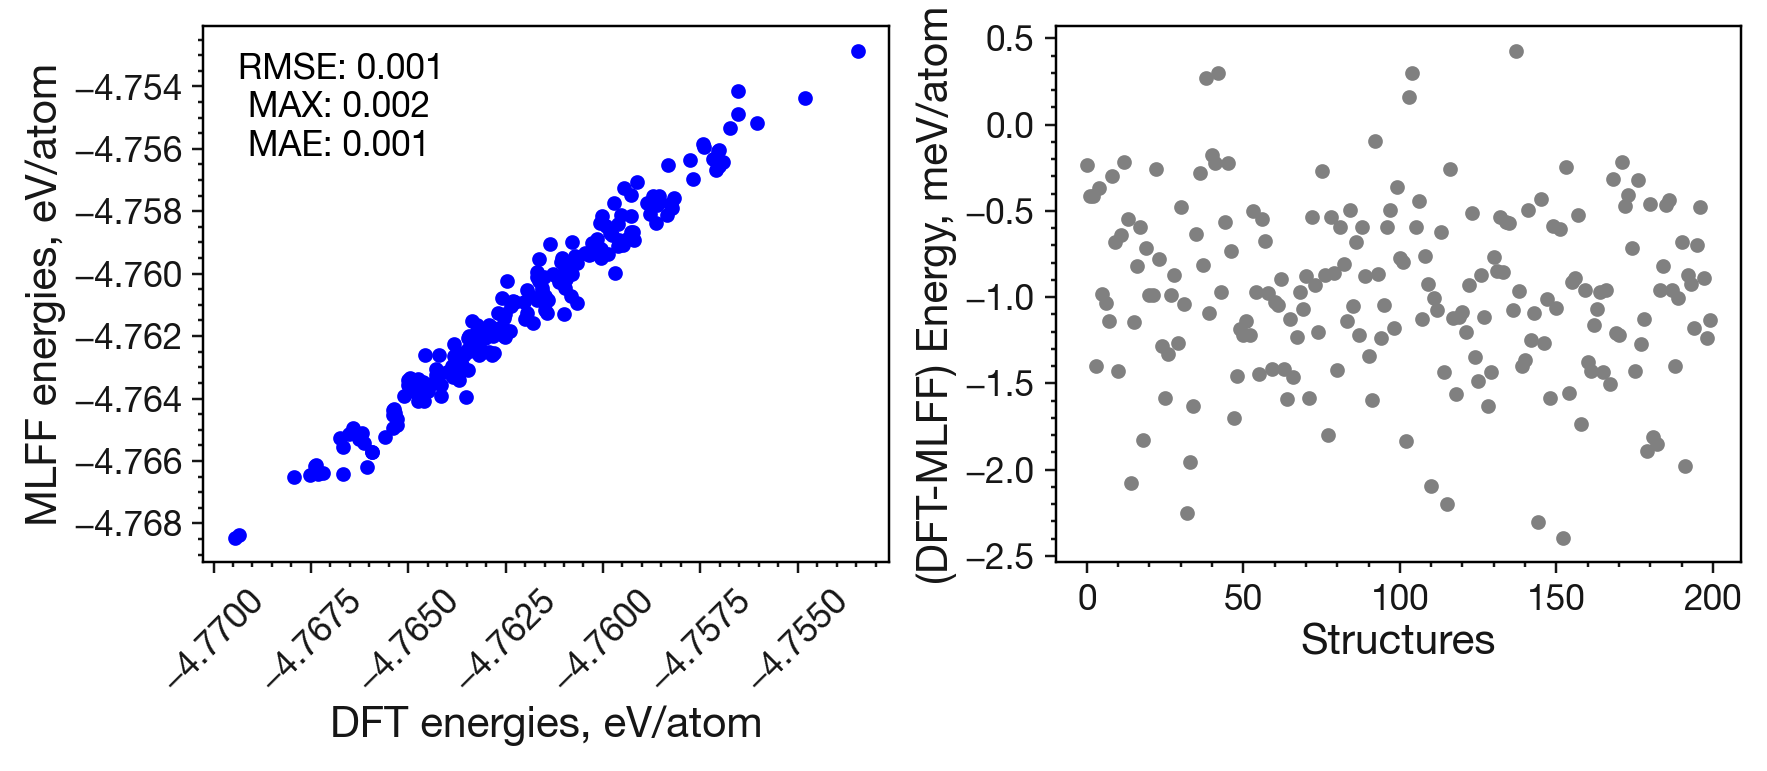

In [7]:
from pymatgen.core import Structure
from pymatgen.io.vasp.outputs import Xdatcar, Vasprun
import os
from os import path
import xml.etree.ElementTree as ET 
import numpy as np
from vasppy.outcar import forces_from_outcar, final_energy_from_outcar
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline
%config InlineBackend.figure_format='retina'

import figure_formatting.figure_formatting as ff
ff.set_formatting() # set default formatting.

dft_relaxed = '/Users/sona/Desktop/Research/project_2/tetragonal-li2sis3/doped/14%P_cont_validation/14%P-doped-system/energy_force_testing/DFT/'
mlff_relaxed_lite = '/Users/sona/Desktop/Research/project_2/tetragonal-li2sis3/doped/14%P_cont_validation/14%P-doped-system/energy_force_testing/ML_FF_litercut5/'

def plot_energy_diff(dft_dir1, mlff_dir1):
    dft_energies = []
    mlff_energies = []

    # go to dft directory and get the number of folders in this directory with integer names
    os.chdir(dft_dir1)
    n_structures1 = len([name for name in os.listdir(".") if os.path.isdir(name)])


    for i in range(1, n_structures1+1):
        e = final_energy_from_outcar(dft_dir1 + f'{i}/' + 'OUTCAR')
        n_atoms = len(Structure.from_file(f'{dft_dir1}{i}/POSCAR'))
        dft_energies.append(float(e/n_atoms))
        m = final_energy_from_outcar(mlff_dir1 + f'{i}/' + 'OUTCAR')
        mlff_energies.append(float(m/n_atoms))
        
    # define root means square error, max error and mean error

    rmse = np.sqrt(np.mean(np.square(np.array(dft_energies) - np.array(mlff_energies))))
    max_error = max(abs(np.array(dft_energies) - np.array(mlff_energies)))
    mean_avg_error = np.mean(abs(np.array(dft_energies) - np.array(mlff_energies)))

    plt.figure(figsize=(7, 3))

    plt.subplot(1, 2, 1)

    plt.scatter(dft_energies, mlff_energies, color = 'blue', s=10)
    plt.xlabel('DFT energies, eV/atom', fontsize=12)
    plt.ylabel('MLFF energies, eV/atom', fontsize=12)
    plt.text(0.05, 0.95, f'RMSE: {rmse:.3f} \n MAX: {max_error:.3f} \n MAE: {mean_avg_error:.3f}', 
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.minorticks_on()
    # plt.legend(loc='center', fontsize=10)
    plt.xticks(fontsize=10, rotation=45)
    plt.yticks(fontsize=10)

    # plt.colorbar()

    e_diff = np.array(dft_energies) - np.array(mlff_energies)
    
    plt.subplot(1, 2, 2)
    plt.scatter(range(len(e_diff)), e_diff*1000, color = 'grey', s=10)
    plt.xlabel('Structures', fontsize=12)
    plt.ylabel('(DFT-MLFF) Energy, meV/atom', fontsize=12)
    plt.minorticks_on()
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.tight_layout()

    plt.show()

# Call the function with your directory paths

plot_energy_diff(dft_relaxed, mlff_relaxed_lite)

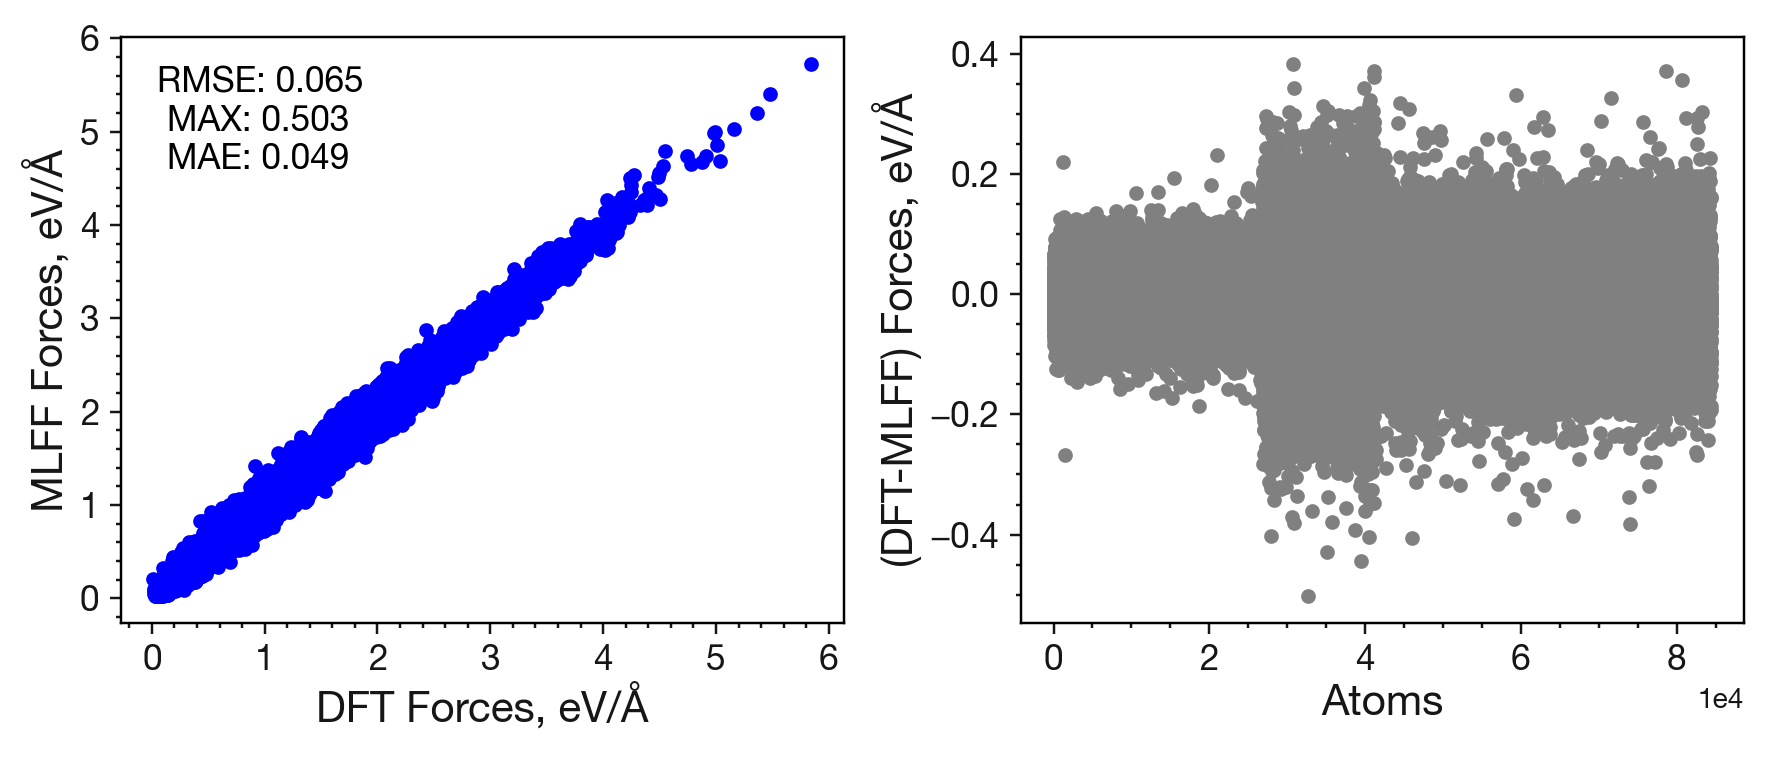

In [8]:
def plot_forces(species, dft_dir1, mlff_dir1):

    os.chdir(dft_dir1)
    n_structures1 = len([name for name in os.listdir(".") if os.path.isdir(name)])
    
    # determining indices of given species
    structure = Structure.from_file(f'{dft_dir1}{1}/POSCAR')
    species_list = []
    for atom in structure:
        species_list.append(atom.species_string)

    if species not in species_list:
        raise ValueError("Selected species not present in structure")
        
    plot_indices = []
    for index, atom in enumerate(species_list):
        if atom == species:
            plot_indices.append(index)

    # dictionary of ml forces

    def get_forces(mlff_dir, dft_dir, n_structures):
        ml_run = {}
        for step in range(1, n_structures+1):
            tree = ET.parse(f'{mlff_dir}{step}/vasprun.xml')
            root = tree.getroot()   
            for structure in root.findall('varray'):
                if 'forces' in structure.attrib['name']:
                    ml_run[step] = {}
                    for atom_index, l in enumerate(structure):
                        l = str(l.text).strip()
                        l = l.split("      ")
                        forces_atom = [float(l[0]),float(l[1]),float(l[2])]
                        ml_run[step][atom_index] = np.linalg.norm(forces_atom)            

        dft_run = {}
        for step in range(1, n_structures+1):
            dft_run[step] = {}
            forces = forces_from_outcar(f'{dft_dir}{step}/OUTCAR')
            for atoms in range(0, len(forces[0])):
                dft_run[step][atoms] = np.linalg.norm(forces[0][atoms])

        return ml_run, dft_run

    ml_run1, dft_run1 = get_forces(mlff_dir1, dft_dir1, n_structures1)

    def get_scalar_forces(ml_run, dft_run, n_structures):
        ml_force = []
        dft_force = []

        for step in range(1, n_structures+1):
            for atom in ml_run[step]:
                if atom in plot_indices:
                    scalar_force = ml_run[step][atom]
                    ml_force.append(scalar_force)

        for step in range(1, n_structures+1):        
            for atom in dft_run[step]:
                if atom in plot_indices:
                    scalar_force = dft_run[step][atom]
                    dft_force.append(scalar_force)
        return ml_force, dft_force

    ml_force, dft_force = get_scalar_forces(ml_run1, dft_run1, n_structures1)

    return ml_force, dft_force

ml_force_li, dft_force_li = plot_forces('Li', dft_relaxed, mlff_relaxed_lite)
ml_force_si, dft_force_si = plot_forces('Si', dft_relaxed, mlff_relaxed_lite)
ml_force_p, dft_force_p = plot_forces('P', dft_relaxed, mlff_relaxed_lite)
ml_force_s, dft_force_s = plot_forces('S', dft_relaxed, mlff_relaxed_lite)

total_force_ml = ml_force_li + ml_force_si + ml_force_p + ml_force_s
total_force_dft = dft_force_li + dft_force_si + dft_force_p + dft_force_s

rmse = np.sqrt(np.mean(np.square(np.array(total_force_dft) - np.array(total_force_ml))))
max_error = max(abs(np.array(total_force_dft) - np.array(total_force_ml)))
mean_avg_error = np.mean(abs(np.array(total_force_dft) - np.array(total_force_ml)))

e_diff = np.array(total_force_dft) - np.array(total_force_ml)

plt.figure(figsize=(7, 3))

plt.subplot(1, 2, 1)
plt.scatter(total_force_dft, total_force_ml, color = 'blue', s=10)
plt.xlabel('DFT Forces, eV/Å', fontsize=12)
plt.ylabel('MLFF Forces, eV/Å', fontsize=12)
plt.text(0.05, 0.95, f'RMSE: {rmse:.3f} \n MAX: {max_error:.3f} \n MAE: {mean_avg_error:.3f}', 
        transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.minorticks_on()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.subplot(1, 2, 2)
plt.scatter(range(len(e_diff)), e_diff, color = 'grey', s=10)
plt.xlabel(f'Atoms', fontsize=12)
plt.ylabel('(DFT-MLFF) Forces, eV/Å', fontsize=12)
plt.minorticks_on()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()

plt.show()

Depending on the property of an interest and system under study variety of other tests could be performed. The general tests are comparison of structure volumes and RDFs from AIMD and MLFF runs. High overlap in volume and RDF show that lattice parameters and surroundings of atoms respectively are well replicated with MLFF.

In [13]:
from pymatgen.core import Structure
from pymatgen.io.vasp.outputs import Xdatcar
import os
from os import path
import xml.etree.ElementTree as ET
from pymatgen.io.vasp.outputs import Vasprun
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

AIMD_dir_780 = '/Users/sona/Desktop/Research/project_2/tetragonal-li2sis3/aimd/780_aimd/'
ML_dir_780 = '/Users/sona/Desktop/Research/project_2/tetragonal-li2sis3/MD/780_md/'
AIMD_dir_500 = '/Users/sona/Desktop/Research/project_2/tetragonal-li2sis3/aimd/500_aimd/'
ML_dir_500 = '/Users/sona/Desktop/Research/project_2/tetragonal-li2sis3/MD/500_md/'
AIMD_dir_300 = '/Users/sona/Desktop/Research/project_2/tetragonal-li2sis3/aimd/300_aimd/'
ML_dir_300 = '/Users/sona/Desktop/Research/project_2/tetragonal-li2sis3/MD/300_md/'


f_u = 4
supercell = 3*3*2

outcar_a_780 = f'{AIMD_dir_780}OUTCAR'
outcar_a_500 = f'{AIMD_dir_500}OUTCAR'
outcar_a_300 = f'{AIMD_dir_300}OUTCAR'

oszicar_a_780 = f'{AIMD_dir_780}OSZICAR'
oszicar_a_500 = f'{AIMD_dir_500}OSZICAR'
oszicar_a_300 = f'{AIMD_dir_300}OSZICAR'

outcar_m_780 = f'{ML_dir_780}OUTCAR'
outcar_m_500 = f'{ML_dir_500}OUTCAR'
outcar_m_300 = f'{ML_dir_300}OUTCAR'

oszicar_m_780 = f'{ML_dir_780}OSZICAR'
oszicar_m_500 = f'{ML_dir_500}OSZICAR'
oszicar_m_300 = f'{ML_dir_300}OSZICAR'

volume_a_780 = []
volume_a_500 = []
volume_a_300 = []

volume_m_780 = []
volume_m_500 = []
volume_m_300 = []

T_a_780 = []
T_a_500 = []
T_a_300 = []

T_m_780 = []
T_m_500 = []
T_m_300 = []


with open(outcar_a_780, mode = 'r') as file:
    lines = file.readlines()

    for line in lines:
        if "volume of cell :" in line:
            volume_a_780.append(float(line.split()[4])/f_u/supercell)

with open(outcar_a_500, mode = 'r') as file:
    lines = file.readlines()

    for line in lines:
        if "volume of cell :" in line:
            volume_a_500.append(float(line.split()[4])/f_u/supercell)

with open(outcar_a_300, mode = 'r') as file:
    lines = file.readlines()

    for line in lines:
        if "volume of cell :" in line:
            volume_a_300.append(float(line.split()[4])/f_u/supercell)

with open(oszicar_a_780, mode = 'r') as file:
    lines = file.readlines()

    for line in lines:
        if "T=" in line:
            T_a_780.append(float(line.split()[2]))

with open(oszicar_a_500, mode = 'r') as file:
    lines = file.readlines()

    for line in lines:
        if "T=" in line:
            T_a_500.append(float(line.split()[2]))

with open(oszicar_a_300, mode = 'r') as file:
    lines = file.readlines()

    for line in lines:
        if "T=" in line:
            T_a_300.append(float(line.split()[2]))

with open(outcar_m_780, mode = 'r') as file:
    lines = file.readlines()

    for line in lines:
        if "volume of cell :" in line:
            volume_m_780.append(float(line.split()[4])/f_u/supercell)

with open(outcar_m_500, mode = 'r') as file:
    lines = file.readlines()

    for line in lines:
        if "volume of cell :" in line:
            volume_m_500.append(float(line.split()[4])/f_u/supercell)

with open(outcar_m_300, mode = 'r') as file:
    lines = file.readlines()

    for line in lines:
        if "volume of cell :" in line:
            volume_m_300.append(float(line.split()[4])/f_u/supercell)

with open(oszicar_m_780, mode = 'r') as file:
    lines = file.readlines()

    for line in lines:
        if "T=" in line:
            T_m_780.append(float(line.split()[2]))

with open(oszicar_m_500, mode = 'r') as file:
    lines = file.readlines()

    for line in lines:
        if "T=" in line:
            T_m_500.append(float(line.split()[2]))

with open(oszicar_m_300, mode = 'r') as file:
    lines = file.readlines()

    for line in lines:
        if "T=" in line:
            T_m_300.append(float(line.split()[2]))

fig = make_subplots(rows=1, cols=1)

fig.add_trace(
    go.Scatter(x=T_a_780, y=volume_a_780, mode='markers', name='AIMD 780', marker={'opacity' : 0.5}), 
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=T_m_780, y=volume_m_780, mode='markers', name='MLFF 780', marker={'opacity' : 0.5}), 
     row=1, col=1
)

fig.add_trace(
    go.Scatter(x=T_a_500, y=volume_a_500, mode='markers', name='AIMD 500', marker={'opacity' : 0.5}), 
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=T_m_500, y=volume_m_500, mode='markers', name='MLFF 500', marker={'opacity' : 0.5}), 
     row=1, col=1
)

fig.add_trace(
    go.Scatter(x=T_a_300, y=volume_a_300, mode='markers', name='AIMD 300', marker={'opacity' : 0.5}), 
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=T_m_300, y=volume_m_300, mode='markers', name='MLFF 300', marker={'opacity' : 0.5}), 
     row=1, col=1
)

fig.update_xaxes(title_text='T, K')
fig.update_yaxes(title_text='Volume/f.u,, A<sup>3</sup>')

fig.show()

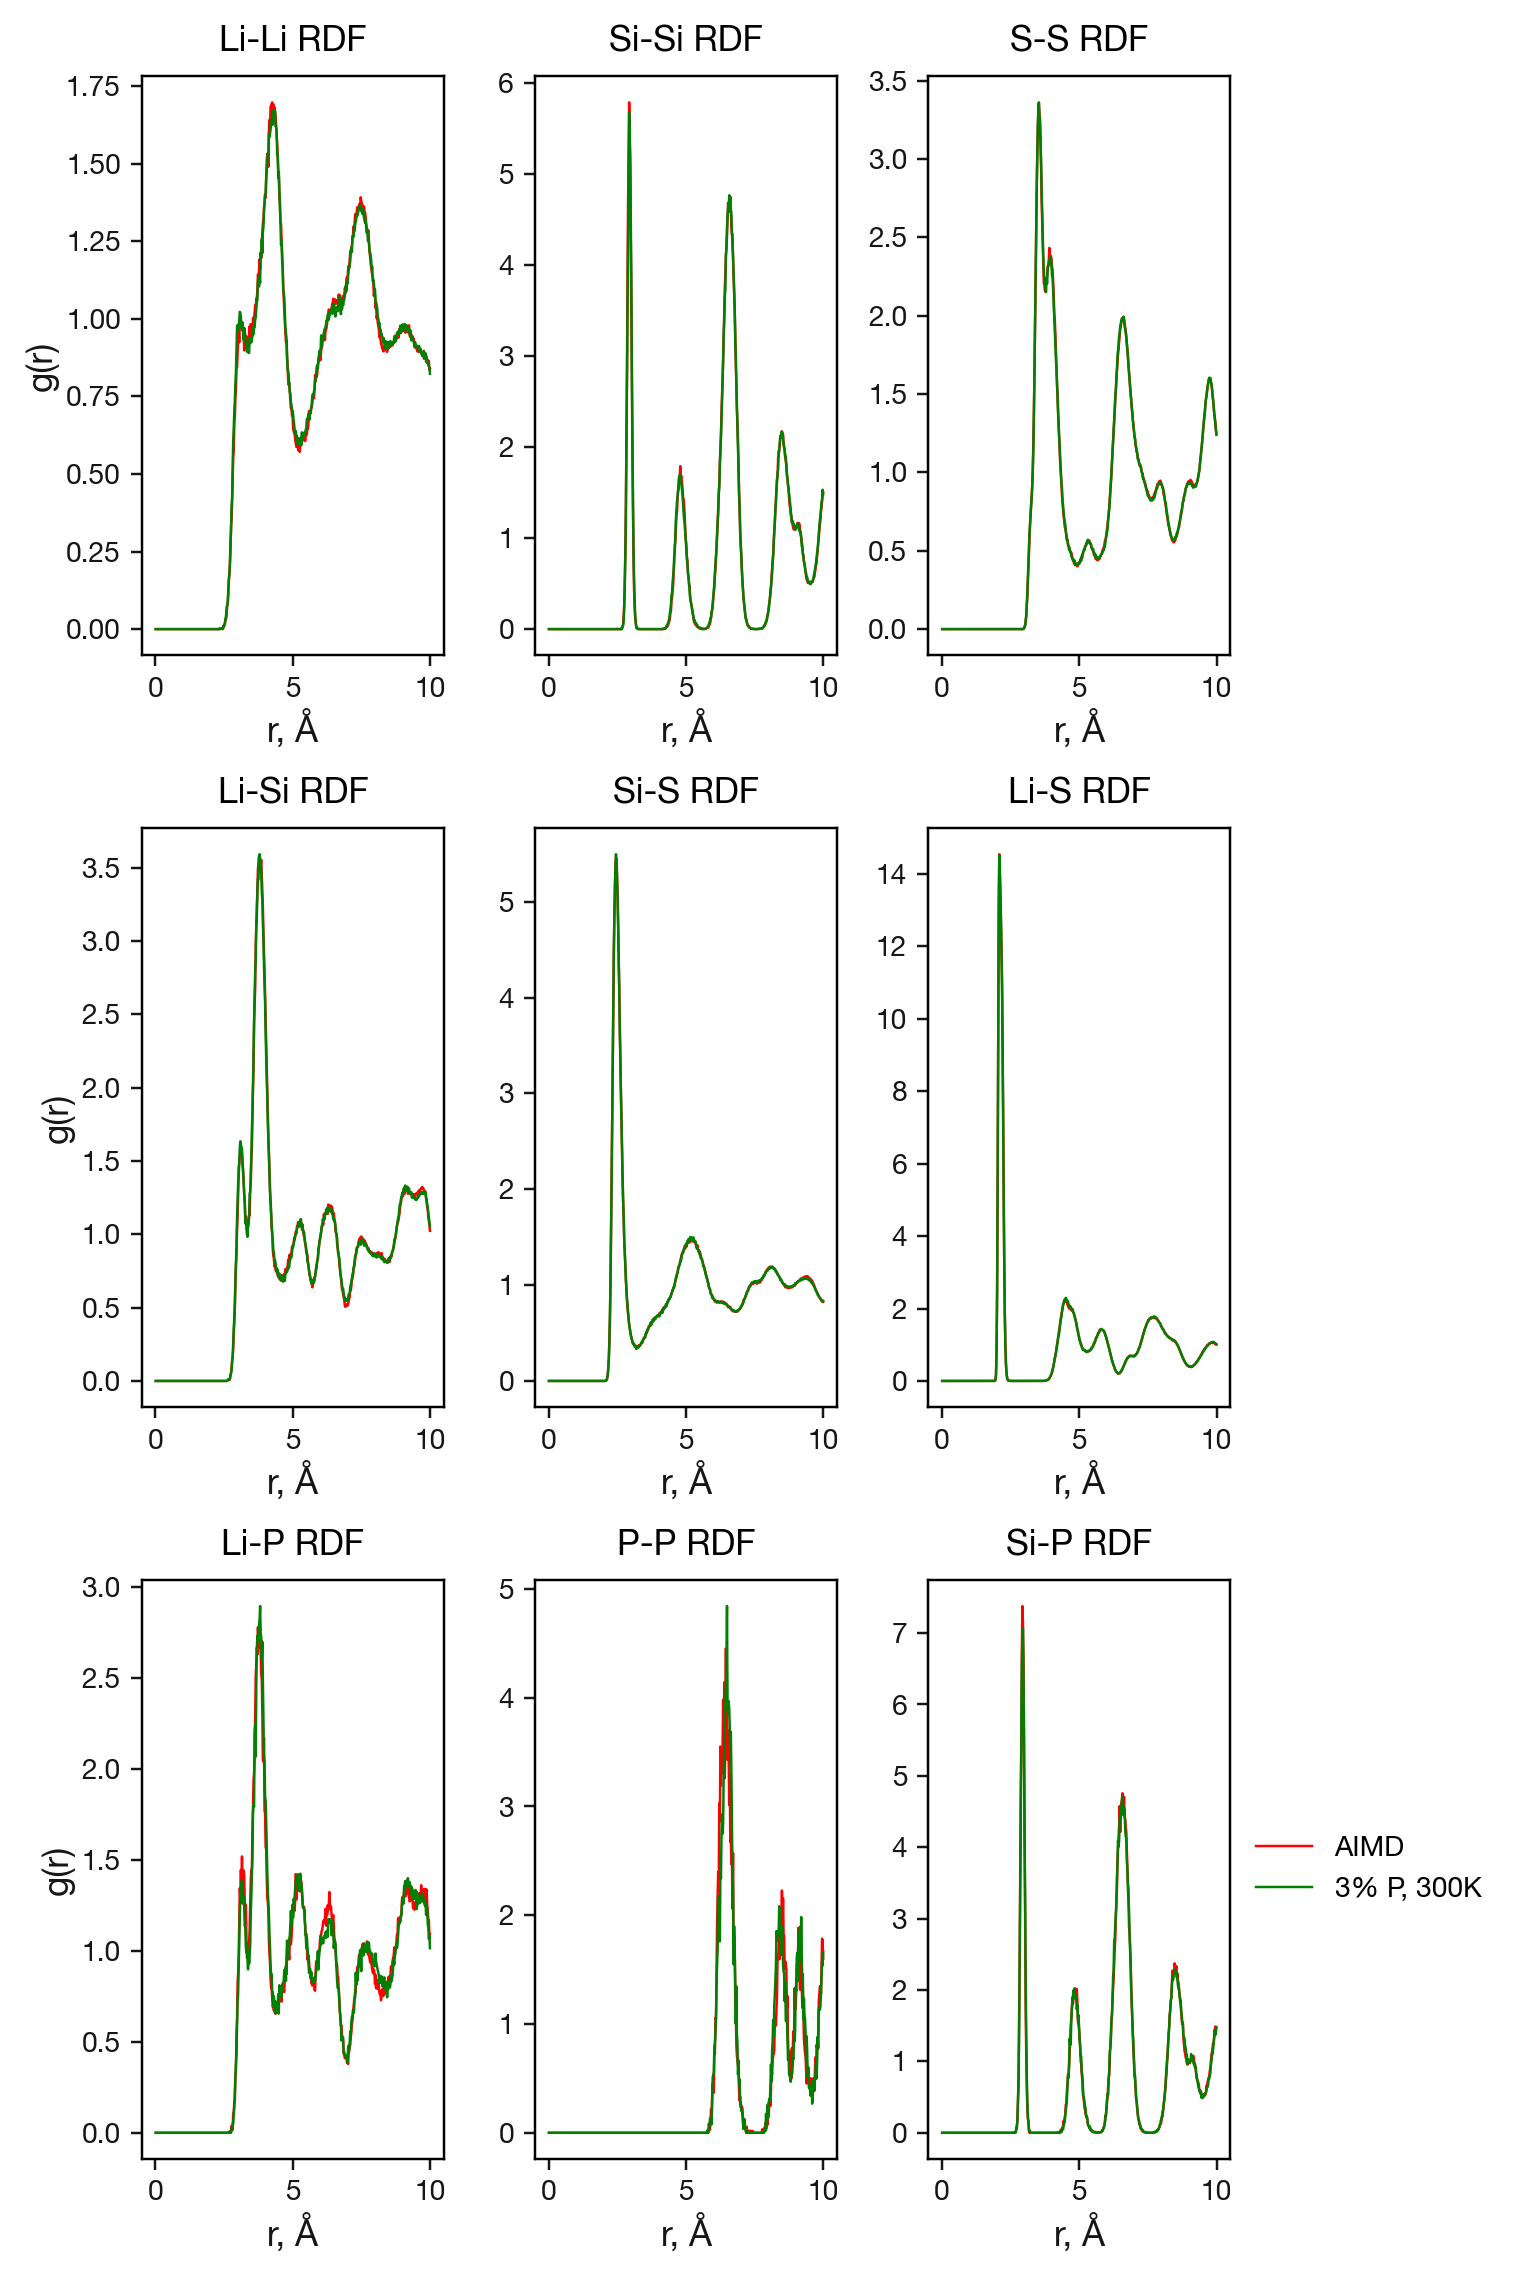

In [15]:
from pymatgen.io.vasp.outputs import Xdatcar
from vasppy.rdf import RadialDistributionFunction
import numpy as np
import matplotlib.pyplot as plt

aimd_dir = '/Users/sona/Desktop/Research/project_2/tetragonal-li2sis3/doped/aimd/14P-300/xdatcars/'
mlff_dir_lite = '/Users/sona/Desktop/Research/project_2/tetragonal-li2sis3/doped/14%P_from_scratch_validation/MSD-RDF-md/30ps-lite/'


xd_aimd = Xdatcar(aimd_dir+'XDATCAR_collated_1-3')

rdf_lili = RadialDistributionFunction.from_species_strings(structures=xd_aimd.structures, species_i='Li')
rdf_lisi = RadialDistributionFunction.from_species_strings(structures=xd_aimd.structures, species_i='Li', species_j='Si')
rdf_lis = RadialDistributionFunction.from_species_strings(structures=xd_aimd.structures, species_i='Li', species_j='S')
rdf_sisi = RadialDistributionFunction.from_species_strings(structures=xd_aimd.structures, species_i='Si')
rdf_sis = RadialDistributionFunction.from_species_strings(structures=xd_aimd.structures, species_i='Si', species_j='S')
rdf_ss = RadialDistributionFunction.from_species_strings(structures=xd_aimd.structures, species_i='S')
rdf_lip = RadialDistributionFunction.from_species_strings(structures=xd_aimd.structures, species_i='Li', species_j='P')
rdf_pp = RadialDistributionFunction.from_species_strings(structures=xd_aimd.structures, species_i='P')
rdf_sip = RadialDistributionFunction.from_species_strings(structures=xd_aimd.structures, species_i='Si', species_j='P')

xd_ml = Xdatcar(mlff_dir_lite+'XDATCAR')

rdf_lili_m = RadialDistributionFunction.from_species_strings(structures=xd_ml.structures, species_i='Li')
rdf_lisi_m = RadialDistributionFunction.from_species_strings(structures=xd_ml.structures, species_i='Li', species_j='Si')
rdf_lis_m = RadialDistributionFunction.from_species_strings(structures=xd_ml.structures, species_i='Li', species_j='S')
rdf_sisi_m = RadialDistributionFunction.from_species_strings(structures=xd_ml.structures, species_i='Si')
rdf_sis_m = RadialDistributionFunction.from_species_strings(structures=xd_ml.structures, species_i='Si', species_j='S')
rdf_ss_m = RadialDistributionFunction.from_species_strings(structures=xd_ml.structures, species_i='S')
rdf_lip_m = RadialDistributionFunction.from_species_strings(structures=xd_ml.structures, species_i='Li', species_j='P')
rdf_pp_m = RadialDistributionFunction.from_species_strings(structures=xd_ml.structures, species_i='P')
rdf_sip_m = RadialDistributionFunction.from_species_strings(structures=xd_ml.structures, species_i='Si', species_j='P')

# plot the RDFs

fig, axes = plt.subplots(3, 3, figsize=(6, 9), sharex=False, sharey=False)

axes[0, 0].plot(rdf_lili.r, rdf_lili.rdf, color='red', label='AIMD')
axes[0, 1].plot(rdf_sisi.r, rdf_sisi.rdf, color='red', label='AIMD')
axes[0, 2].plot(rdf_ss.r, rdf_ss.rdf, color='red', label='AIMD')
axes[1, 0].plot(rdf_lisi.r, rdf_lisi.rdf, color='red', label='AIMD')
axes[1, 1].plot(rdf_lis.r, rdf_lis.rdf, color='red', label='AIMD')
axes[1, 2].plot(rdf_sis.r, rdf_sis.rdf, color='red', label='AIMD')
axes[2, 0].plot(rdf_lip.r, rdf_lip.rdf, color='red', label='AIMD')
axes[2, 1].plot(rdf_pp.r, rdf_pp.rdf, color='red', label='AIMD')
axes[2, 2].plot(rdf_sip.r, rdf_sip.rdf, color='red', label='AIMD')

axes[0, 0].plot(rdf_lili_m.r, rdf_lili_m.rdf, color='green', label='3% P, 300K')
axes[0, 1].plot(rdf_sisi_m.r, rdf_sisi_m.rdf, color='green', label='3% P, 300K')
axes[0, 2].plot(rdf_ss_m.r, rdf_ss_m.rdf, color='green', label='3% P, 300K')
axes[1, 0].plot(rdf_lisi_m.r, rdf_lisi_m.rdf, color='green', label='3% P, 300K')
axes[1, 1].plot(rdf_lis_m.r, rdf_lis_m.rdf, color='green', label='3% P, 300K')
axes[1, 2].plot(rdf_sis_m.r, rdf_sis_m.rdf, color='green', label='3% P, 300K')
axes[2, 0].plot(rdf_lip_m.r, rdf_lip_m.rdf, color='green', label='3% P, 300K')
axes[2, 1].plot(rdf_pp_m.r, rdf_pp_m.rdf, color='green', label='3% P, 300K')
axes[2, 2].plot(rdf_sip_m.r, rdf_sip_m.rdf, color='green', label='3% P, 300K')

# Add titles and labels
axes[0, 0].set_title('Li-Li RDF', fontsize=10, loc='center')
axes[0, 1].set_title('Si-Si RDF', fontsize=10, loc='center')
axes[0, 2].set_title('S-S RDF', fontsize=10, loc='center')
axes[1, 0].set_title('Li-Si RDF', fontsize=10, loc='center')
axes[1, 1].set_title('Si-S RDF', fontsize=10, loc='center')
axes[1, 2].set_title('Li-S RDF', fontsize=10, loc='center')
axes[2, 0].set_title('Li-P RDF', fontsize=10, loc='center')
axes[2, 1].set_title('P-P RDF', fontsize=10, loc='center')
axes[2, 2].set_title('Si-P RDF', fontsize=10, loc='center')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


axes[0, 0].set_ylabel('g(r)', fontsize=10)
axes[1, 0].set_ylabel('g(r)', fontsize=10)
axes[2, 0].set_ylabel('g(r)', fontsize=10)
axes[1, 0].set_xlabel('r, Å', fontsize=10)
axes[1, 1].set_xlabel('r, Å', fontsize=10)
axes[1, 2].set_xlabel('r, Å', fontsize=10)
axes[0, 0].set_xlabel('r, Å', fontsize=10)
axes[0, 1].set_xlabel('r, Å', fontsize=10)
axes[0, 2].set_xlabel('r, Å', fontsize=10)
axes[2, 0].set_xlabel('r, Å', fontsize=10)
axes[2, 1].set_xlabel('r, Å', fontsize=10)
axes[2, 2].set_xlabel('r, Å', fontsize=10)

plt.tight_layout()
plt.show()

Since this example is on a solid electrolyte where calculating ionic conduction properties is major use case of MLFF, we compare short and long timescale MLFF and AIMD dynamics by computing velocity autocorrelation function (VACF) and mean square displacement (MSD) plots respectively.

100%|██████████| 10/10 [00:42<00:00,  4.23s/it]


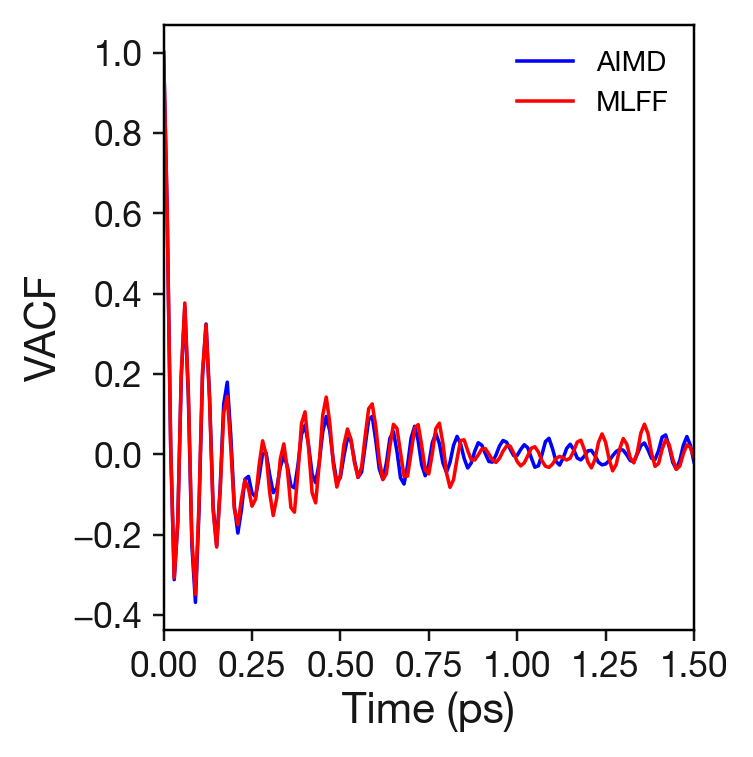

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from py4vasp import Calculation
import scipy.linalg
from tqdm import tqdm
import matplotlib.pyplot as plt


%matplotlib inline
%config InlineBackend.figure_format='retina'

import figure_formatting.figure_formatting as ff
ff.set_formatting() # set default formatting.

aimd_dir = '/Users/sona/Desktop/Research/project_2/tetragonal-li2sis3/doped/aimd/14P-600/14%P-600-nvt-2/'
mlff_dir_lite = '/Users/sona/Desktop/Research/project_2/tetragonal-li2sis3/doped/14%P_cont_validation/14%P-doped-system/VACF-md/10ps_litercut5/'

velocities_aimd = Calculation.from_path(aimd_dir).velocity[:690:1].read()['velocities']
velocities_mlff_lite = Calculation.from_path(mlff_dir_lite).velocity[:690:1].read()['velocities']

velocities_aimd_li = velocities_aimd[:, 0:134, :]
velocities_mlff_li_lite = velocities_mlff_lite[:, 0:134, :]
velocities_aimd_si = velocities_aimd[:, 134:196, :]
velocities_mlff_si_lite = velocities_mlff_lite[:, 134:196, :]
velocities_aimd_p = velocities_aimd[:, 196:206, :]
velocities_mlff_p_lite = velocities_mlff_lite[:, 196:206, :]
velocities_aimd_s = velocities_aimd[:, 206:422, :]
velocities_mlff_s_lite = velocities_mlff_lite[:, 206:422, :]

N_frames = velocities_aimd_li.shape[0]    # use same number of frames for both calculations
N_block = 5
timestep = 2                              # in fs
dt = timestep * N_block                   # single interval length for velocity outputing
t = np.arange(0, N_frames*dt, dt)         # time array

def vacf(velocities, atoms):
    
    correlation_matrix = []

    for n in tqdm(range(atoms)):
        correlation_list = []
        
        for k in range(0, len(velocities), 1):
            buffer_sum = 0
            denominator = len(range(0, len(velocities) - k))
            
            for j in range(0, len(velocities) - k):
                velocity_vector_1 = velocities[j][n, :]
                velocity_vector_2 = velocities[k + j][n, :]
                
                dot_product = np.sum(velocity_vector_1 * velocity_vector_2)
                norm_product = scipy.linalg.norm(velocity_vector_1) * scipy.linalg.norm(velocity_vector_2)
                buffer_sum += dot_product / norm_product
            # buffer sum is the sum of the correlation terms for each moving frame 
            correlation_list.append(buffer_sum / denominator)
            # correlation list is the averaged correlation values for each frame
        correlation_matrix.append(correlation_list)
        # in correlation matrix we end up with 
        
    correlation_matrix = np.array(correlation_matrix)

    correlation_matrix = np.mean(correlation_matrix, axis=0)

    return correlation_matrix

vacf_aimd_p = vacf(velocities_aimd_p, 10)
vacf_mlff_p_lite = vacf(velocities_mlff_p_lite, 10)

plt.figure(figsize=(3, 3))
plt.plot(t/1000, vacf_aimd_p, 'b-', linewidth=1, label='AIMD')
plt.plot(t/1000, vacf_mlff_p_lite, 'r-', linewidth=1, label='MLFF')
plt.legend(loc='best')
plt.xlabel('Time (ps)', fontsize=12)
plt.ylabel('VACF', fontsize=12)
plt.xlim(0, 1.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Taking Fourier transform of VACF gives us power spectrum. Good agreement in overall shape of power spectrum for every constituent element indicates that lattice vibrations for framework atoms (P, Si, S) and short time scale vibrational dynamics for diffusion ion (Li) is captured accurately by the forcefield.

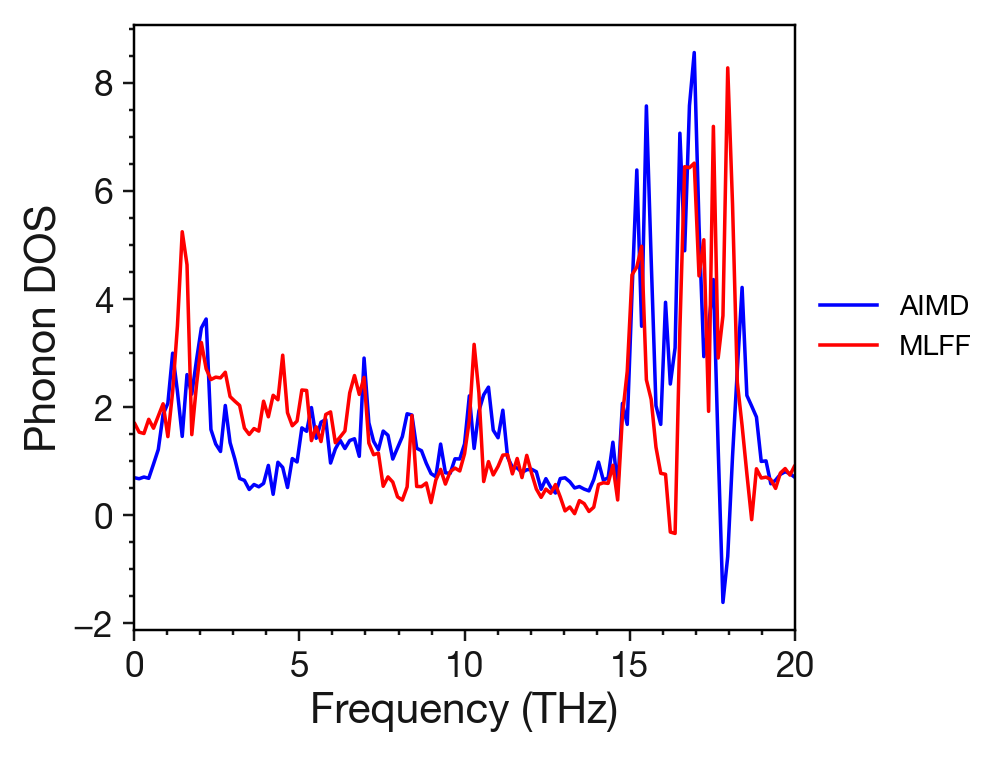

In [20]:
def VACF_fft(VACF, dt):
    VACF_fft = np.fft.fft(VACF)
    VACF_fft = np.fft.fftshift(VACF_fft)
    freq = np.fft.fftfreq(len(VACF), d=dt)
    freq = np.fft.fftshift(freq)
    return VACF_fft, freq

VACF_fft_aimd, freq = VACF_fft(vacf_aimd_p, dt)
VACF_fft_mlff_lite, freq = VACF_fft(vacf_mlff_p_lite, dt)

plt.figure(figsize=(4, 3))
plt.plot(freq*1000, VACF_fft_aimd.real, 'b-', linewidth=1, label='AIMD')
plt.plot(freq*1000, VACF_fft_mlff_lite.real, 'r-', linewidth=1, label='MLFF')
plt.xlabel('Frequency (THz)', fontsize=12)
plt.ylabel('Phonon DOS', fontsize=12)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(0, 20)
plt.minorticks_on()
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Finding Means and Variances: 100%|██████████| 100/100 [00:00<00:00, 113.16it/s]


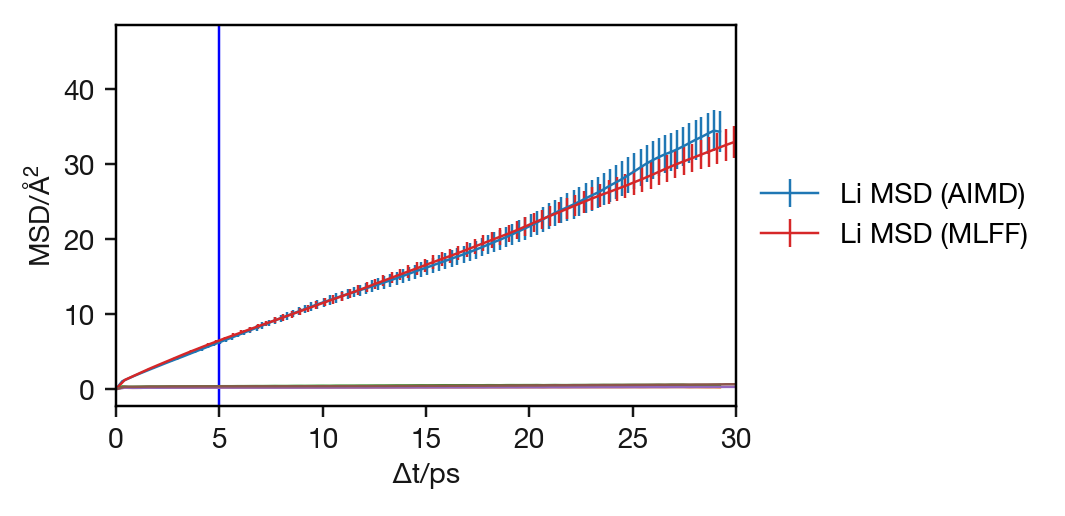

In [23]:
from pymatgen.core import Structure
from pymatgen.io.vasp.outputs import Xdatcar
import matplotlib.pyplot as plt
import numpy as np
from kinisi.analyze import DiffusionAnalyzer, ConductivityAnalyzer, JumpDiffusionAnalyzer
from kinisi.diffusion import Bootstrap
from kinisi.arrhenius import StandardArrhenius
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format='retina'

import figure_formatting.figure_formatting as ff
ff.set_formatting() # set default formatting.

aimd_dir = '/Users/sona/Desktop/Research/project_2/tetragonal-li2sis3/aimd/600/xdatcars/'
mlff_dir_lite = '/Users/sona/Desktop/Research/project_2/tetragonal-li2sis3/MD/validationmd/xdatcars_600_mich/'

temp = 600

# for Aimd
p_param_li = {'specie': 'Li',
            'time_step': 20.0,
            'step_skip': 1}


p_param_si = {'specie': 'Si',
            'time_step': 20.0,
            'step_skip': 1}


p_param_s = {'specie': 'S',
            'time_step': 20.0,
            'step_skip': 1}

# for ML

p_param_li_m = {'specie': 'Li',
            'time_step': 2.0,
            'step_skip': 10}

p_param_si_m = {'specie': 'Si',
            'time_step': 2.0,
            'step_skip': 10}

p_param_s_m = {'specie': 'S',
            'time_step': 2.0,
            'step_skip': 10}

xd_a = Xdatcar(aimd_dir +'XDATCAR_collated_5-8')
diff_li_a = DiffusionAnalyzer.from_Xdatcar(xd_a, parser_params=p_param_li)
diff_si_a = DiffusionAnalyzer.from_Xdatcar(xd_a, parser_params=p_param_si)
diff_s_a = DiffusionAnalyzer.from_Xdatcar(xd_a, parser_params=p_param_s)

xd_m_lite = Xdatcar(mlff_dir_lite +'XDATCAR_collated_1-2')
diff_li_m = DiffusionAnalyzer.from_Xdatcar(xd_m_lite, parser_params=p_param_li_m)
diff_si_m = DiffusionAnalyzer.from_Xdatcar(xd_m_lite, parser_params=p_param_si_m)
diff_s_m = DiffusionAnalyzer.from_Xdatcar(xd_m_lite, parser_params=p_param_s_m)

plt.errorbar(diff_li_a.dt, diff_li_a.msd, diff_li_a.msd_std, label='Li MSD (AIMD)')
plt.errorbar(diff_si_a.dt, diff_si_a.msd, diff_si_a.msd_std)
plt.errorbar(diff_s_a.dt, diff_s_a.msd, diff_s_a.msd_std)

plt.errorbar(diff_li_m.dt, diff_li_m.msd, diff_li_m.msd_std, label='Li MSD (MLFF)')
plt.errorbar(diff_si_m.dt, diff_si_m.msd, diff_si_m.msd_std)
plt.errorbar(diff_s_m.dt, diff_s_m.msd, diff_s_m.msd_std)

plt.axvline(5, color='b')

plt.ylabel('MSD/Å$^2$')
plt.xlabel('$\Delta t$/ps')
plt.xlim(0, 30)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



### Retraining
MLFF training in VASP is very versatile. This comes from the way it stores both the structures and local configurations in ML_AB file. Since it stores structures, it is possible to reselect local configurations by using a different cutoff, changing the number of expansion terms in radial and angular descriptors and their weight in fitting. Since it stores also local configurations, it is possible to refit with different sparsification criterion or different matrix equation solver. It is also possible to train MLFF for two different polymorphs and combine them into a single MLFF to study phase transition. These are all examples of MLFF retraining.

It is recommended to train FF with same weight for energies, forces and stresses to maximize accuracy in all of them. However, for a specific application retraining using higher weights for one of these elements could be favorable. This type of retraining biases accuracy towards prediction of one type of property, and is useful for applications that demand high accuracy for the said property. 

Following is a script for retraining. NSW is set to 0 and ML_CTIFOR to very high value so that no new FP calculation gets performed. ML_ISTART = 1, so structures and local configurations are taken from ML_AB file and new force field is fitted with new cutoffs specified using single value decomposition (SVD). Setting ML_MB to a value smaller than maximum number of local configurations in ML_AB will produce a lighter potential - thus retraining can be used to generate a range of potentials with different cutoffs, accuracy and speed to test and use where needed. 


In [ ]:
SYSTEM         = Li2SiS3_tetragonal_780_retrain
### Electronic structure part
PREC           = Normal
ADDGRID        = .TRUE.
GGA            = PS
ALGO           = Fast
ENCUT          = 650
EDIFF          = 1e-6
NELM           = 400
NELMIN         = 6
ISPIN          = 1  
ISYM           = 0
ISMEAR         = 0  
SIGMA          = 0.05

### MD part 
IBRION         = 0 
ISIF           = 3
MDALGO         = 3
NSW            = 0 
POTIM          = 1 
NCORE          = 32
NBLOCK         = 20
TEBEG          = 780
TEEND          = 780
RANDOM_SEED    = 743491 0 0
LANGEVIN_GAMMA   = 10.0  10.0  10.0
LANGEVIN_GAMMA_L = 3.0

### Output part
LREAL          = Auto
LWAVE          = .FALSE.
LCHARG         = .FALSE.

### ML primary tags
ML_LMLFF = .TRUE.
ML_ISTART = 1
ML_IALGO_LINREG = 3
ML_RCUT2 = 6.0
ML_RCUT1 = 6.0
ML_CTIFOR = 1000
ML_MB = 4000
ML_LBASIS_DISCARD = .TRUE.